In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import os
import sys
import cv2

In [2]:
# DB connection info
import psycopg2
from my_secrets import DB_HOST_NAME, DB_USER_NAME, DB_PASSWORD, DB_NAME

# connection info
host = DB_HOST_NAME
user = DB_USER_NAME
password = DB_PASSWORD
database = DB_NAME

# conn
connection = psycopg2.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

cursor = connection.cursor()

In [3]:
# fetch columns
sql_fetch_columns = '''
SELECT column_name
FROM information_schema.columns
WHERE table_name = 'movenet_output';
'''
cursor.execute(sql_fetch_columns)
columns = cursor.fetchall()
print(columns)

[('id',), ('nose_y',), ('nose_x',), ('left_eye_y',), ('left_eye_x',), ('right_eye_y',), ('right_eye_x',), ('left_ear_y',), ('left_ear_x',), ('right_ear_y',), ('right_ear_x',), ('left_shoulder_y',), ('left_shoulder_x',), ('right_shoulder_y',), ('right_shoulder_x',), ('left_elbow_y',), ('left_elbow_x',), ('right_elbow_y',), ('right_elbow_x',), ('left_wrist_y',), ('left_wrist_x',), ('right_wrist_y',), ('right_wrist_x',), ('left_hip_y',), ('left_hip_x',), ('right_hip_y',), ('right_hip_x',), ('left_knee_y',), ('left_knee_x',), ('right_knee_y',), ('right_knee_x',), ('left_ankle_y',), ('left_ankle_x',), ('right_ankle_y',), ('right_ankle_x',), ('posture',), ('location',)]


In [4]:
# fetch data
tcolumns = [i[0] for i in columns]
cursor.execute('SELECT * FROM movenet_output')
df = pd.DataFrame(cursor.fetchall(), columns=tcolumns)
df.head()

,id,nose_y,nose_x,left_eye_y,left_eye_x,right_eye_y,right_eye_x,left_ear_y,left_ear_x,right_ear_y,...,left_knee_y,left_knee_x,right_knee_y,right_knee_x,left_ankle_y,left_ankle_x,right_ankle_y,right_ankle_x,posture,location
0,1,0.184862,0.155119,0.159507,0.125211,0.112799,0.327314,0.301197,0.804482,0.719604,...,0.211495,0.222745,0.784424,0.708398,0.460858,0.278325,0.524914,0.304973,normal,https://encrypted-tbn0.gstatic.com/images?q=tb...
1,2,0.148218,0.116185,0.119818,0.130200,0.130977,0.315744,0.308677,0.604722,0.556595,...,0.605400,0.591207,0.807304,0.751771,0.363102,0.373793,0.286190,0.479780,normal,https://encrypted-tbn0.gstatic.com/images?q=tb...
2,3,0.201224,0.162821,0.165268,0.185704,0.188370,0.420231,0.432878,0.783617,0.806308,...,0.557573,0.586443,0.246741,0.266430,0.683550,0.643869,0.711764,0.677170,normal,https://encrypted-tbn0.gstatic.com/images?q=tb...
3,4,0.256837,0.214902,0.220202,0.236568,0.248398,0.483920,0.496212,0.723264,0.820087,...,0.822562,0.822823,0.433912,0.299431,0.829540,0.782347,0.770973,0.677139,normal,https://encrypted-tbn0.gstatic.com/images?q=tb...
4,5,0.144416,0.121002,0.114458,0.099077,0.136368,0.379824,0.385363,0.828224,0.848321,...,0.645897,0.644336,0.318028,0.286984,0.482182,0.417118,0.623668,0.621056,normal,https://encrypted-tbn0.gstatic.com/images?q=tb...


In [18]:
# split data
X = df.iloc[:,1:].select_dtypes('number')
y = df['posture'].copy()

class_names = y.unique()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train)
X_train.shape, X_val.shape, X_test.shape

((1434, 34), (478, 34), (638, 34))

In [19]:
encode_target_dict = {k:v for k, v in zip(sorted(class_names), range(len(class_names)))}
encode_target_dict

{'forward_head': 0, 'leaning': 1, 'normal': 2}

In [20]:
y_train = y_train.map(encode_target_dict)
y_val = y_val.map(encode_target_dict)
y_test = y_test.map(encode_target_dict)

In [21]:
# 분류 모델 생성
inputs = tf.keras.Input(shape=(34))

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(inputs)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense_3 (Dense)             (None, 128)               4480      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 12,931


Trainable params: 12,931
Non-trainable params: 0
_________________________________________________________________


In [22]:
# 컴파일
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

In [24]:
# 실행
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
52/90 [================>.............] - ETA: 0s - loss: 1.1480 - accuracy: 0.3425 
Epoch 1: val_accuracy improved from -inf to 0.51046, saving model to weights.best.hdf5
90/90 [==============================] - 1s 3ms/step - loss: 1.1260 - accuracy: 0.3570 - val_loss: 1.0526 - val_accuracy: 0.5105
Epoch 2/200
55/90 [=================>............] - ETA: 0s - loss: 1.0671 - accuracy: 0.4080
Epoch 2: val_accuracy improved from 0.51046 to 0.59623, saving model to weights.best.hdf5
90/90 [==============================] - 0s 2ms/step - loss: 1.0588 - accuracy: 0.4282 - val_loss: 1.0019 - val_accuracy: 0.5962
Epoch 3/200
78/90 [=========================>....] - ETA: 0s - loss: 1.0257 - accuracy: 0.4824
Epoch 3: val_accuracy improved from 0.59623 to 0.65481, saving model to weights.best.hdf5
90/90 [==============================] - 0s 2ms/step - loss: 1.0222 - accuracy: 0.4847 - val_loss: 0.9420 - val_accuracy: 0.6548
Epoch 4/200
53/90 [================>.............] - ETA: 0s

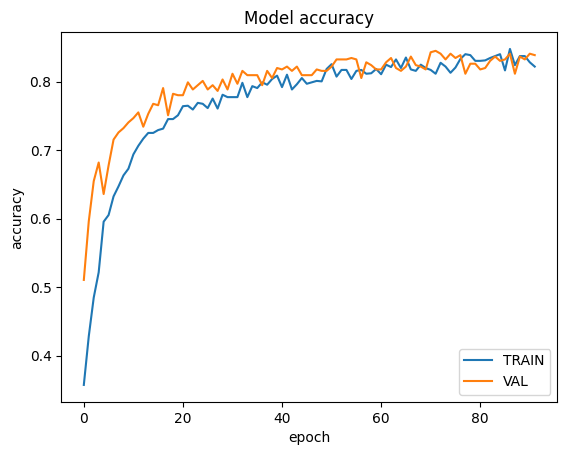

In [25]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [26]:
# Evaluate the model using the TEST dataset
model.load_weights(checkpoint_path)
loss, accuracy = model.evaluate(X_test, y_test)

20/20 [==============================] - 0s 916us/step - loss: 0.3943 - accuracy: 0.8448


20/20 [==============================] - 0s 699us/step
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

forward_head       0.90      0.88      0.89       214
     leaning       0.82      0.83      0.83       200
      normal       0.81      0.82      0.82       224

    accuracy                           0.84       638
   macro avg       0.85      0.84      0.85       638
weighted avg       0.85      0.84      0.85       638



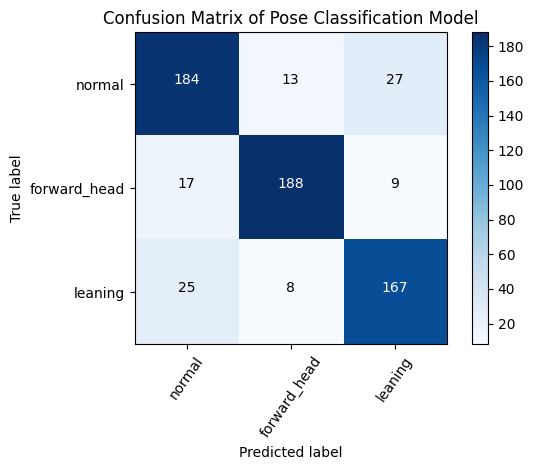

In [27]:
import itertools

# cm
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in y_test]

# Plot the confusion matrix
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [187]:
import pickle

with open('my_model.pkl', 'wb') as file:
    pickle.dump(model, file)